# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание данных**

Данные находятся в файле /datasets/autos.csv.

* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

Целевой признак
* Price — цена (евро)

## Подготовка данных

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgbm
from catboost import CatBoostRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
    
import time

In [ ]:
try:
    data = pd.read_csv('autos.csv')
except:
    try:
        data  = pd.read_csv('/datasets/autos.csv')
    except:
        print('Ошибка. Проверьте путь к файлу')

In [ ]:
data.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [ ]:
#Основная информация о датафрейме
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Данные представлены 16 признаками и содержат 354 369 строк.

Целесообразно изменить название столбцов и формат некоторых признаков.

In [ ]:
#Изменение названия колонок
data.columns = ['Date_Crawled', 'Price', 'Vehicle_Type', 'Registration_Year', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'Registration_Month', 'Fuel_Type', 'Brand',
       'Repaired', 'Date_Created', 'Number_Of_Pictures', 'Postal_Code',
       'Last_Seen']

#Приведение названия колонок к нижнему регистру
data.columns = data.columns.str.lower()

#Изменение формата 
data['date_crawled'] = pd.to_datetime(data['date_crawled'])
data['date_created'] = pd.to_datetime(data['date_created'])
data['last_seen'] = pd.to_datetime(data['last_seen'])


Посмотрим оснувную статистику датасета.

In [ ]:
data.describe(include='all', datetime_is_numeric=True)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
count,354369,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.0,354369.000000,354369
unique,NaN,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,NaN,NaN,NaN,NaN
top,NaN,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,NaN,NaN,NaN,NaN
freq,NaN,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,NaN,NaN,NaN,NaN
mean,2016-03-21 12:58:10.450648320,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,2016-03-20 19:12:07.753274112,0.0,50508.689087,2016-03-29 23:51:00.667456768
min,2016-03-05 14:06:22,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,2014-03-10 00:00:00,0.0,1067.000000,2016-03-05 14:15:08
25%,2016-03-13 11:52:33,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,2016-03-13 00:00:00,0.0,30165.000000,2016-03-23 02:50:03
50%,2016-03-21 17:50:55,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,2016-03-21 00:00:00,0.0,49413.000000,2016-04-03 15:15:51
75%,2016-03-29 14:37:20,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,2016-03-29 00:00:00,0.0,71083.000000,2016-04-06 10:15:19
max,2016-04-07 14:36:58,20000.000000,NaN,9999.000000,NaN,20000.000000,NaN,150000.000000,12.000000,NaN,NaN,NaN,2016-04-07 00:00:00,0.0,99998.000000,2016-04-07 14:58:51


Из основной статистики по датасету выделяются несколько странных моментов:
* Максимальное значение года регистрации в столбце "registration_year": 9999, минимальное: 1000
* Максимальное значение мощности в столбце "power": 20000, минимальное: 0
* Минимальная цена в столбце "price": 0
* Минимальное значение месяца регистрации: 0

Рассмотрим каждый из признаков по отдельности.

**Цена**

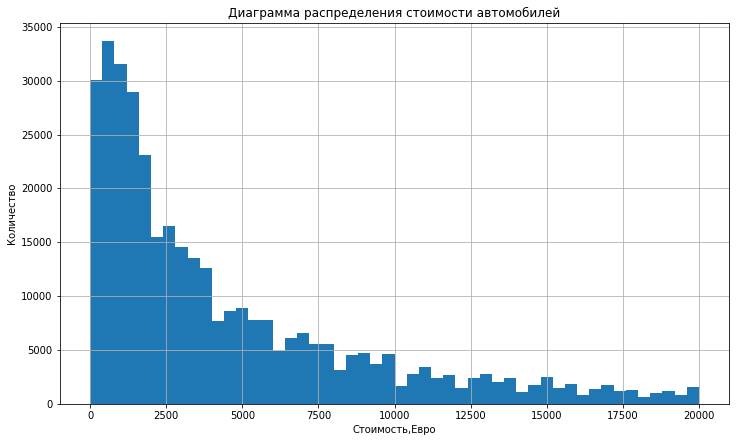

In [ ]:
data['price'].hist(bins=50,figsize=(12,7))
plt.title('Диаграмма распределения стоимости автомобилей')
plt.xlabel('Стоимость,Евро')
plt.ylabel('Количество')
plt.show()

Присутствующие нулевые значения цены точно стоит удалить. Однако в выборке много других непрадоподобно низких значений. 

Определим нижний порог в 10 евро.

In [ ]:
data_prepared = data[data['price'] > 10]

**Год регистрации автомобиля**

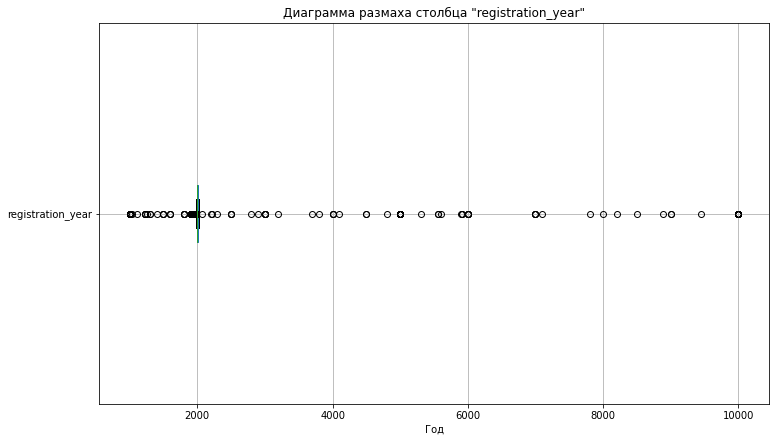

In [ ]:
data_prepared.boxplot(column='registration_year', figsize=(12, 7), vert=False)
plt.title('Диаграмма размаха столбца "registration_year"')
plt.xlabel('Год')
plt.show()

In [ ]:
#Уникальные значения в столбце registration_year
data_prepared['registration_year'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 1910, 2016,
       2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994, 1991,
       1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989,
       2015, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988, 1980,
       1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977,
       1961, 1966, 1975, 1963, 1964, 1960, 5000, 1958, 1967, 1956, 3200,
       1000, 1941, 9999, 8888, 1500, 2200, 4100, 1962, 1929, 1957, 1940,
       3000, 2066, 1949, 2019, 1937, 1951, 1800, 1959, 1953, 1954, 1234,
       8000, 5300, 9000, 2900, 6000, 5900, 5911, 1400, 1950, 4000, 1948,
       1952, 8500, 1932, 1255, 3700, 3800, 4800, 1942, 7000, 1935, 1933,
       1936, 1923, 2290, 1930, 1001, 9450, 1944, 2500, 1943, 1938, 1934,
       1928, 5555, 5600, 1600, 1111, 2222, 1039, 1300, 2800, 1931, 4500,
       1602, 7800, 1947, 1927, 7100, 8200, 1946])

Часть значений года регистрации автомобиля явно не корректны. Удалим все года, не попадающие в интервал от 1910 до 2016

In [ ]:
data_prepared = data_prepared[(data_prepared['registration_year'] <= 2016)&(data_prepared['registration_year'] >= 1910)]
data

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19,0,87439,2016-04-07 07:15:26


Посмотрим получившийся boxplot.

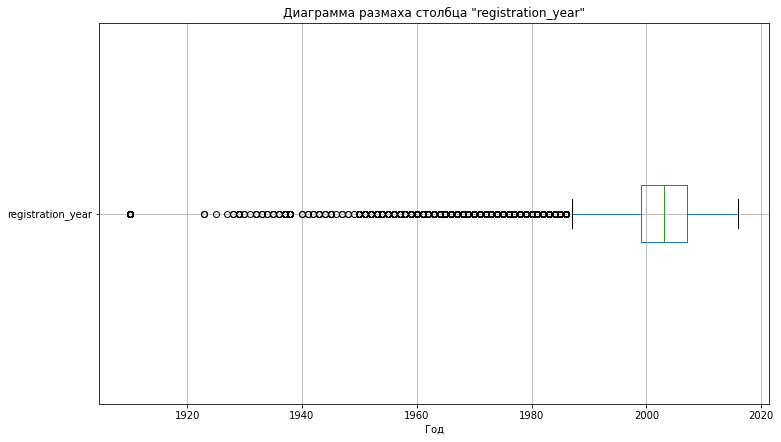

In [ ]:
data_prepared.boxplot(column='registration_year', figsize=(12, 7), vert=False)
plt.title('Диаграмма размаха столбца "registration_year"')
plt.xlabel('Год')
plt.show()

Осталось большое количество выбросов со значениями года регистрации раньше 1985-1990. Однако удалять их все будет не корректно.

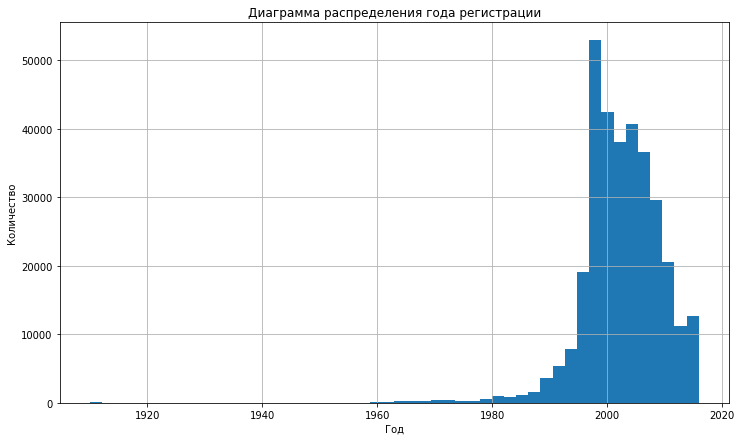

In [ ]:
data_prepared['registration_year'].hist(bins=50, figsize=(12,7))
plt.title('Диаграмма распределения года регистрации')
plt.xlabel('Год')
plt.ylabel('Количество')
plt.show()

На гистограмме видно условную границу на значении 1960. Удалим значения ниже.

In [ ]:
data_prepared = data_prepared[data_prepared['registration_year'] >= 1960]

**Мощность**

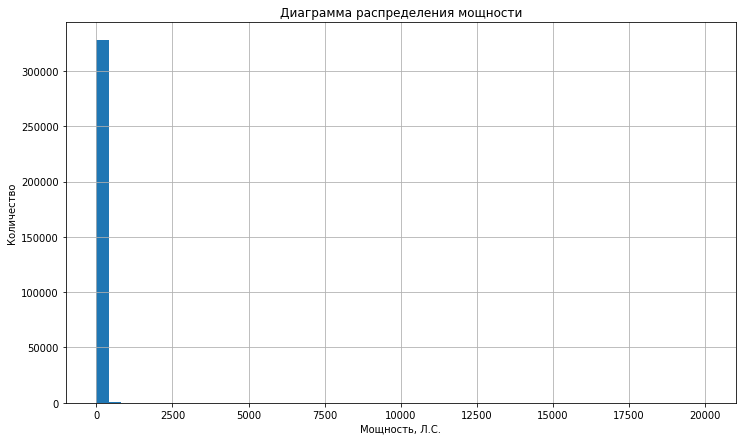

In [ ]:
data_prepared['power'].hist(bins=50, figsize=(12,7))
plt.title('Диаграмма распределения мощности')
plt.xlabel('Мощность, Л.С.')
plt.ylabel('Количество')
plt.show()

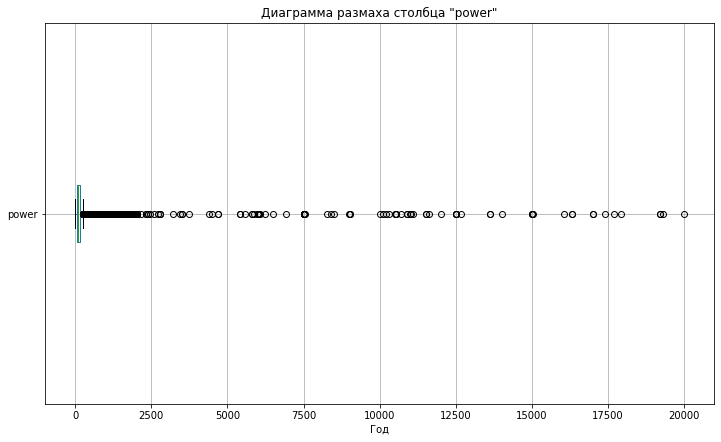

In [ ]:
data_prepared.boxplot(column='power', figsize=(12, 7), vert=False)
plt.title('Диаграмма размаха столбца "power"')
plt.xlabel('Год')
plt.show()

В значениях мощноти встречаются неправдоподобно большие значения. Самый мощный двигатель в мире для машины серийного производства демонстрирует мощность в 2040 л/с, значения выше этого явно не корректные.

In [ ]:
data_prepared = data_prepared[(data_prepared['power'] < 2040) & (data_prepared['power'] != 0)]

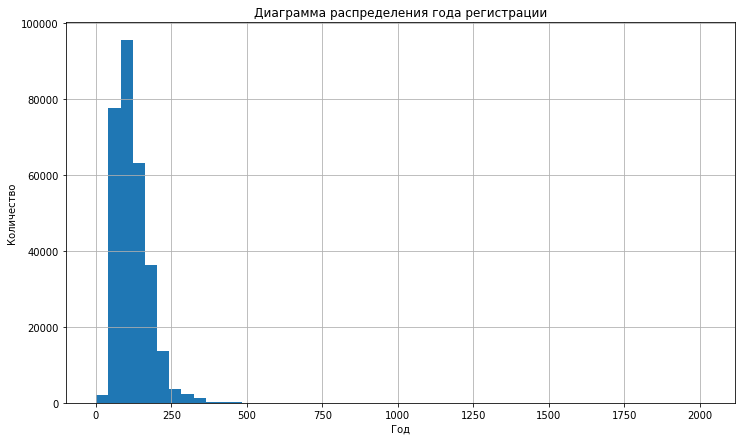

In [ ]:
data_prepared['power'].hist(bins=50, figsize=(12,7))
plt.title('Диаграмма распределения года регистрации')
plt.xlabel('Год')
plt.ylabel('Количество')
plt.show()

Выберем верхнюю границу для мощности равную 500 л.с.

In [ ]:
data_prepared = data_prepared[data_prepared['power'] <= 500]

Отберем признаки, которые потребуются для построения модели: 
* date_crawled — дата скачивания анкеты из базы - неважный признак, нак не влияет на стоимость.
* vehicle_type — тип автомобильного кузова - важный признак, определяющий функционал автомобиля.
* registration_year — год регистрации автомобиля - важный признак, определяет, сколько автомобиль находится в эксплуатации.
* gearbox — тип коробки передач - важный признак, механическая КПП стоит ниже, чем автомат.
* power — мощность (л. с.) - важный признак, одна из основных характеристик автомобиля.
* model — модель автомобиля - важный признак, объединяет в себе несколько других.
* kilometer — пробег (км) - важный признак, чем выше пробег, тем выше износ, и, как следствие, ниже стоимость.
* registration_month — месяц регистрации автомобиля - неважный признак, учитывая, что разброс измеряется годами.
* FuelType — тип топлива - важный признак.
* Brand — марка автомобиля - важный признак, марка существенно влияет на стоимость, так как у потребителя есть представление о качестве продукта конкретной компании.
* repaired — была машина в ремонте или нет - важный признак, ремонт и замена деталей снижает надежность автомобиля.
* date_created — дата создания анкеты - неважный признак.
* number_of_pictures — количество фотографий автомобиля - неважный признак.
* postal_code — почтовый индекс владельца анкеты (пользователя) - неважный признак.
* last_seen — дата последней активности пользователя - неважный признак.

In [ ]:
#Список важных признаков
importatnt_columns = ['price', 
                      'vehicle_type', 
                      'registration_year', 
                      'gearbox',
                      'power', 
                      'model', 
                      'kilometer',  
                      'fuel_type',
                      'brand', 
                      'repaired']

data_prepared = data_prepared[importatnt_columns]
data_prepared.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


**Обработка пропусков**

In [ ]:
#Процентное количество пропусков по каждому параметру.
def isna_view (df):
    return  (
                (df.isna().mean()*100)
                .sort_values(ascending=False)
                .to_frame()
                .rename(columns = {0:'percent_space'})
                .style.background_gradient('coolwarm').format("{:.1f}")
            )

isna_view (data_prepared)

,percent_space
repaired,14.4
fuel_type,5.2
model,3.7
vehicle_type,3.7
gearbox,1.8
price,0.0
registration_year,0.0
power,0.0
kilometer,0.0
brand,0.0


Пропуски есть в столбцах "repaired", "vehicle_type", "fuel_type", "gearbox" и "model".

Для "model" пропущенные значения можно заполнить unknown

In [ ]:
data_prepared['model'] = data_prepared['model'].fillna('unknown')
data_prepared['vehicle_type'] = data_prepared['vehicle_type'].fillna('unknown')
data_prepared['repaired'] = data_prepared['repaired'].fillna('unknown')
data_prepared['fuel_type'] = data_prepared['fuel_type'].fillna('unknown')

data_prepared.dropna(subset=['gearbox'], inplace=True)
data_prepared.dropna(subset=['gearbox'], inplace=True)

In [ ]:
isna_view (data_prepared)

,percent_space
price,0.0
vehicle_type,0.0
registration_year,0.0
gearbox,0.0
power,0.0
model,0.0
kilometer,0.0
fuel_type,0.0
brand,0.0
repaired,0.0


In [ ]:
print('Количество строк до предобработки:', data.shape[0])
print('Количество строк после предобработки:', data_prepared.shape[0])
print('Потеряно:', (data.shape[0] - data_prepared.shape[0])/data.shape[0], '%')

Количество строк до предобработки: 354369
Количество строк после предобработки: 290337
Потеряно: 0.18069300644243713 %


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

In [ ]:
data_prepared.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290337 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              290337 non-null  int64 
 1   vehicle_type       290337 non-null  object
 2   registration_year  290337 non-null  int64 
 3   gearbox            290337 non-null  object
 4   power              290337 non-null  int64 
 5   model              290337 non-null  object
 6   kilometer          290337 non-null  int64 
 7   fuel_type          290337 non-null  object
 8   brand              290337 non-null  object
 9   repaired           290337 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.4+ MB


**Подготовка данных к обучению**

Категориальные признаки необходимо преобразовать методом прямого кодирования, удалив первые столбцы для избежания дамми-ловушки.

In [ ]:
data_prepared.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


In [ ]:
#Список категориальных признаков
category_columns = ['vehicle_type', 
                    'gearbox',
                    'model', 
                    'fuel_type',
                    'brand', 
                    'repaired']

#Кодирование OHE
data_prepared_OHE = data_prepared 
data_prepared_OHE = pd.get_dummies(data_prepared, columns=category_columns)


#Кодирование OE
encoder = OrdinalEncoder()
data_prepared_OE = data_prepared
data_prepared_OE[category_columns] = encoder.fit_transform(data_prepared[category_columns])


Выполним разделение на тренировочную и валидационную выборки.

#Разделение признаков и целевой переменной
features = data_prepared.drop(columns='price')
target = data_prepared['price']

#Разделение выборки на тренировочную и тестовую
features_train, features_test, target_train, target_test = train_test_split(
    features, 
    target, 
    test_size=0.25, 
    train_size=0.75)

In [ ]:
#Разделение признаков и целевой переменной
features_OHE = data_prepared_OHE.drop(columns='price')
target_OHE = data_prepared_OHE['price']

#Разделение на тренировочную, валидационную и тестовую выборки.
features_train_OHE, features_temp_OHE, target_train_OHE, target_temp_OHE = train_test_split(
    features_OHE, 
    target_OHE, 
    test_size=0.4, 
    train_size=0.6)

features_valid_OHE, features_test_OHE, target_valid_OHE, target_test_OHE = train_test_split(
    features_temp_OHE, 
    target_temp_OHE, 
    test_size = 0.5, 
    train_size =0.5)

print(f'Размер обучающей выборки OHE: {features_train_OHE.shape}')
print(f'Размер валидационной выборки OHE: {features_valid_OHE.shape}')
print(f'Размер тестовой выборки OHE: {features_test_OHE.shape}')

print('*'*50)

#Разделение признаков и целевой переменной
features_OE = data_prepared_OE.drop(columns='price')
target_OE = data_prepared_OE['price']

#Разделение на тренировочную, валидационную и тестовую выборки.
features_train_OE, features_temp_OE, target_train_OE, target_temp_OE = train_test_split(
    features_OE, 
    target_OE, 
    test_size=0.4, 
    train_size=0.6)

features_valid_OE, features_test_OE, target_valid_OE, target_test_OE = train_test_split(
    features_temp_OE, 
    target_temp_OE, 
    test_size = 0.5, 
    train_size =0.5)

print(f'Размер обучающей выборки OE: {features_train_OE.shape}')
print(f'Размер валидационной выборки OE: {features_valid_OE.shape}')
print(f'Размер тестовой выборки OE: {features_test_OE.shape}')

Размер обучающей выборки OHE: (174202, 315)
Размер валидационной выборки OHE: (58067, 315)
Размер тестовой выборки OHE: (58068, 315)
**************************************************
Размер обучающей выборки OE: (174202, 9)
Размер валидационной выборки OE: (58067, 9)
Размер тестовой выборки OE: (58068, 9)


Выполним масштабирование признаков путем стандартизации данных.

In [ ]:
#Названия признаков, содержащих числовые значения
numeric = ['registration_year', 'power', 'kilometer']

scaler = StandardScaler()
scaler.fit(features_train_OHE[numeric])
features_train_OHE[numeric] = scaler.transform(features_train_OHE[numeric])
features_valid_OHE[numeric] = scaler.transform(features_valid_OHE[numeric])
features_test_OHE[numeric] = scaler.transform(features_test_OHE[numeric])


print(features_train_OHE.shape)
print(features_valid_OHE.shape)
print(features_test_OHE.shape)

print('*'*50)

scaler = StandardScaler()
scaler.fit(features_train_OE[numeric])
features_train_OE[numeric] = scaler.transform(features_train_OE[numeric])
features_valid_OE[numeric] = scaler.transform(features_valid_OE[numeric])
features_test_OE[numeric] = scaler.transform(features_test_OE[numeric])

print(features_train_OE.shape)
print(features_valid_OE.shape)
print(features_test_OE.shape)

/tmp/ipykernel_85/1167851719.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train_OHE[numeric] = scaler.transform(features_train_OHE[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_85/1167851719.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

(174202, 315)
(58067, 315)
(58068, 315)
**************************************************
(174202, 9)
(58067, 9)
(58068, 9)


/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_85/1167851719.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_test_OE[numeric] = scaler.transform(features_test_OE[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

## Обучение моделей

Обучим несколько моделей, оценивая их качество метрикой MAE, и замеряя время обучения и предсказания.

**LinearRegression**

In [ ]:
%%time
#Обучение модели
start = time.time()
model_LR = LinearRegression()
model_LR = model_LR.fit(features_train_OHE, target_train_OHE)
train_LR = time.time() - start

#Предсказание модели
start = time.time()
predictions_LR = model_LR.predict(features_valid_OHE) 
result_LR = mean_squared_error(target_valid_OHE, predictions_LR, squared=False)
predict_LR = time.time() - start

print("RMSE:", result_LR)
print('Время обучения модели', train_LR)
print('Время предсказания модели',predict_LR)

RMSE: 2524.6899554300344
Время обучения модели 17.924330234527588
Время предсказания модели 0.11875009536743164
CPU times: user 12 s, sys: 6.06 s, total: 18.1 s
Wall time: 18 s


**RandomForestRegressor**

In [ ]:
%%time
#Обучение модели
start = time.time()
model_RFR = RandomForestRegressor(
    random_state=12345, 
    criterion='mse', 
    n_estimators=300)
model_RFR.fit(features_train_OE, target_train_OE)
train_RFR = time.time() - start

#Предсказание модели
start = time.time()
predictions_RFR = model_RFR.predict(features_valid_OE) 
result_RFR = (mean_squared_error(target_valid_OE, predictions_RFR))**0.5
predict_RFR = time.time() - start

print("RMSE:", result_RFR)
print('Время обучения модели', train_RFR)
print('Время предсказания модели',predict_RFR)

RMSE: 1586.645062673646
Время обучения модели 121.50795578956604
Время предсказания модели 6.598031759262085
CPU times: user 2min 6s, sys: 1.59 s, total: 2min 7s
Wall time: 2min 8s


**CatBoostRegressor**

In [ ]:
%%time
#Обучение модели
start = time.time()
model_CAT = CatBoostRegressor(random_state=123,learning_rate=0.4, verbose=100, n_estimators=1000)
model_CAT.fit(features_train_OE, target_train_OE, eval_set=(features_valid_OE, target_valid_OE))
train_CAT = time.time() - start

#Предсказание модели
start = time.time()
predictions_CAT = model_CAT.predict(features_valid_OE)
result_CAT = (mean_squared_error(target_valid_OE, predictions_CAT))**0.5
predict_CAT = time.time() - start

print("RMSE:", result_CAT)
print('Время обучения модели', train_CAT)
print('Время предсказания модели',predict_CAT)

0:	learn: 3512.0155933	test: 3495.1041838	best: 3495.1041838 (0)	total: 23.1ms	remaining: 23.1s
100:	learn: 1610.4353905	test: 1654.7530502	best: 1654.7530502 (100)	total: 2.19s	remaining: 19.5s
200:	learn: 1531.0063391	test: 1606.3920251	best: 1606.3101104 (199)	total: 4.36s	remaining: 17.3s
300:	learn: 1483.7893984	test: 1581.7496460	best: 1581.7304563 (299)	total: 6.53s	remaining: 15.2s
400:	learn: 1447.9887091	test: 1566.5014716	best: 1566.5014716 (400)	total: 8.82s	remaining: 13.2s
500:	learn: 1421.7163673	test: 1557.0585616	best: 1557.0585616 (500)	total: 11s	remaining: 10.9s
600:	learn: 1401.2421374	test: 1551.2621399	best: 1551.1238917 (590)	total: 13.1s	remaining: 8.7s
700:	learn: 1382.4087874	test: 1545.5991748	best: 1545.5634720 (699)	total: 15.3s	remaining: 6.51s
800:	learn: 1366.3482573	test: 1541.5985589	best: 1541.3624213 (798)	total: 17.5s	remaining: 4.34s
900:	learn: 1353.5170931	test: 1539.5648260	best: 1539.5648260 (900)	total: 19.6s	remaining: 2.15s
999:	learn: 1340

**LGBMRegressor**

In [ ]:
%%time
#Обучение модели
start = time.time()
model_LGB = lgbm.sklearn.LGBMRegressor(n_estimators=1000, random_state=12345, learning_rate=0.4, objective='rmse')
model_LGB.fit(features_train_OE, target_train_OE, eval_set=(features_valid_OE, target_valid_OE), verbose=100)
end = time.time()
train_LGB = time.time() - start

#Предсказание модели
start = time.time()
predictions_LGB = model_LGB.predict(features_valid_OE)
result_LGB = (mean_squared_error(target_valid_OE, predictions_LGB))**0.5
predict_LGB = time.time() - start

print("RMSE:", result_LGB)
print('Время обучения модели', train_LGB)
print('Время предсказания модели',predict_LGB)

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's rmse: 1591.81
[200]	valid_0's rmse: 1565.06
[300]	valid_0's rmse: 1554.1
[400]	valid_0's rmse: 1548.88
[500]	valid_0's rmse: 1541.44
[600]	valid_0's rmse: 1537.89
[700]	valid_0's rmse: 1536.91
[800]	valid_0's rmse: 1538.09
[900]	valid_0's rmse: 1538.89
[1000]	valid_0's rmse: 1540.15
RMSE: 1540.149874438612
Время обучения модели 333.8690915107727
Время предсказания модели 4.533081531524658
CPU times: user 5min 33s, sys: 2.6 s, total: 5min 36s
Wall time: 5min 38s


## Анализ моделей

Полученные при обучении моделей результаты сведем в таблицу для наглядности.

In [ ]:
#Результаты моделей
result_tab = pd.DataFrame(
    index=['RMSE','Скорость обучения модели','Скорость предсказания модели'], 
    columns=[
        'LinearRegression',
        'RandomForestRegressor',
        'CatBoostRegressor',
        'LGBMRegressor'])
result_tab['LinearRegression'] = result_LR, train_LR, predict_LR
result_tab['RandomForestRegressor'] = result_RFR, train_RFR, predict_RFR
result_tab['CatBoostRegressor'] = result_CAT, train_CAT, predict_CAT
result_tab['LGBMRegressor'] = result_LGB, train_LGB, predict_LGB
result_tab

,LinearRegression,RandomForestRegressor,CatBoostRegressor,LGBMRegressor
RMSE,2524.689955,1586.645063,1535.805593,1540.149874
Скорость обучения модели,17.924330,121.507956,24.767786,333.869092
Скорость предсказания модели,0.118750,6.598032,0.061962,4.533082


Проверим качество CatBoostRegressor на тестовой выборке.

In [ ]:
%%time

#Предсказание модели
start = time.time()
predictions_CAT = model_CAT.predict(features_test_OE)
result_CAT_test = (mean_squared_error(target_test_OE, predictions_CAT))**0.5
predict_CAT_test = time.time() - start

print("RMSE:", result_CAT_test)
print('Время предсказания модели',predict_CAT_test)

RMSE: 1554.3935430244965
Время предсказания модели 0.05555081367492676
CPU times: user 53.9 ms, sys: 3.98 ms, total: 57.9 ms
Wall time: 55.9 ms


По условию задания, критерии, которые важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

Лучшее качество предсказания показала модель CatBoostRegressor, но с небольшим отрывом идет LGBMRegressor, который существенно отстает по скорости обучения и предсказания. Учитывая высокую скорость работы, лучшей моделью можно назвать CatBoostRegressor.